# 0. Import Necessary Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Please change your directory into the directory of the notebooks folder.
%cd /content/drive/MyDrive/pj/notebooks

Mounted at /content/drive
/content/drive/MyDrive/pj/notebooks


In [2]:
%pip install -r ../requirements.txt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.6 MB/s eta 0:00:00
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=d54c566665896edb9347bc734f59131f0f342e64005b90d675699a6237a02f1a
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import os,json,sys,re
os.sys.path.append('../src')
from config import *
sns.set_theme(style="whitegrid")
raw_dataset = load_dataset("glue", TASK)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

# 1. Visualization of Results

## 1.1 Dataset Check

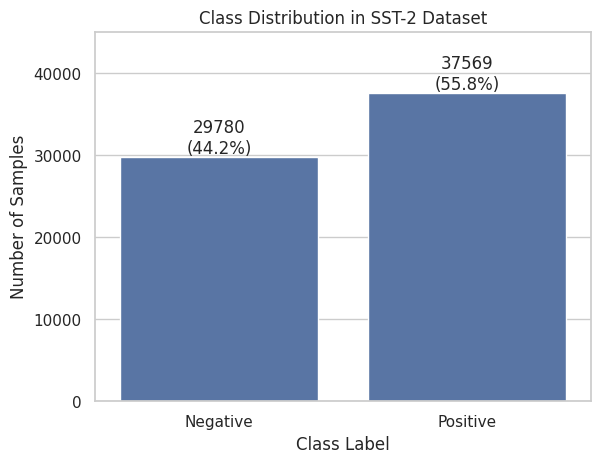

In [ ]:
label_map = {0: 'Negative', 1: 'Positive'}
df_train = pd.DataFrame(raw_dataset['train'])
df_train['label'] = df_train['label'].map(label_map)

ax = sns.countplot(x='label', data=df_train)
plt.title('Class Distribution in SST-2 Dataset')

total = len(df_train)
for p in ax.patches:
    count = int(p.get_height())
    percentage = count / total * 100

    ax.annotate(f'{count}\n({percentage:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)
plt.ylim(0, max([p.get_height() for p in ax.patches]) * 1.2)
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.savefig('../results/figures/class_distribution_sst2.png', dpi=300)
plt.show()

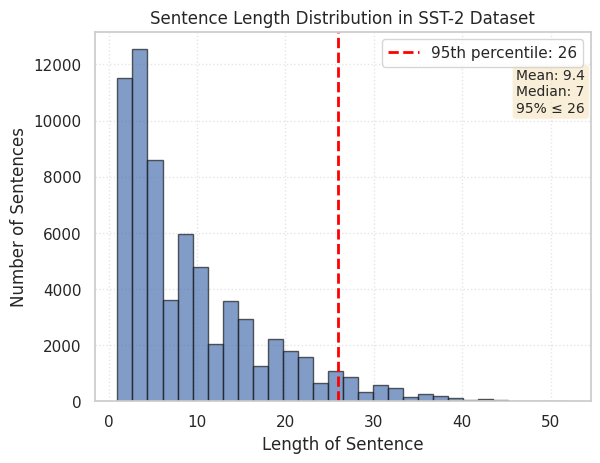

In [ ]:
sentence_lengths = [len(sentence.split()) for sentence in raw_dataset['train']['sentence']]

# Calculate 95% point
p95 = int(pd.Series(sentence_lengths).quantile(0.95))
stats = pd.Series(sentence_lengths).describe(percentiles=[0.25, 0.5, 0.75, 0.95])
textstr = f"Mean: {stats['mean']:.1f}\nMedian: {stats['50%']:.0f}\n95% ≤ {int(stats['95%'])}"
plt.gca().text(0.85, 0.90, textstr, transform=plt.gca().transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.hist(sentence_lengths, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(p95, color='red', linestyle='--', linewidth=2, label=f'95th percentile: {p95}')
plt.title('Sentence Length Distribution in SST-2 Dataset')
plt.xlabel('Length of Sentence')
plt.ylabel('Number of Sentences')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.savefig('../results/figures/sentence_length_distribution_sst2.png', dpi=300)
plt.show()

## 1.2 Efficiency Tradeoff

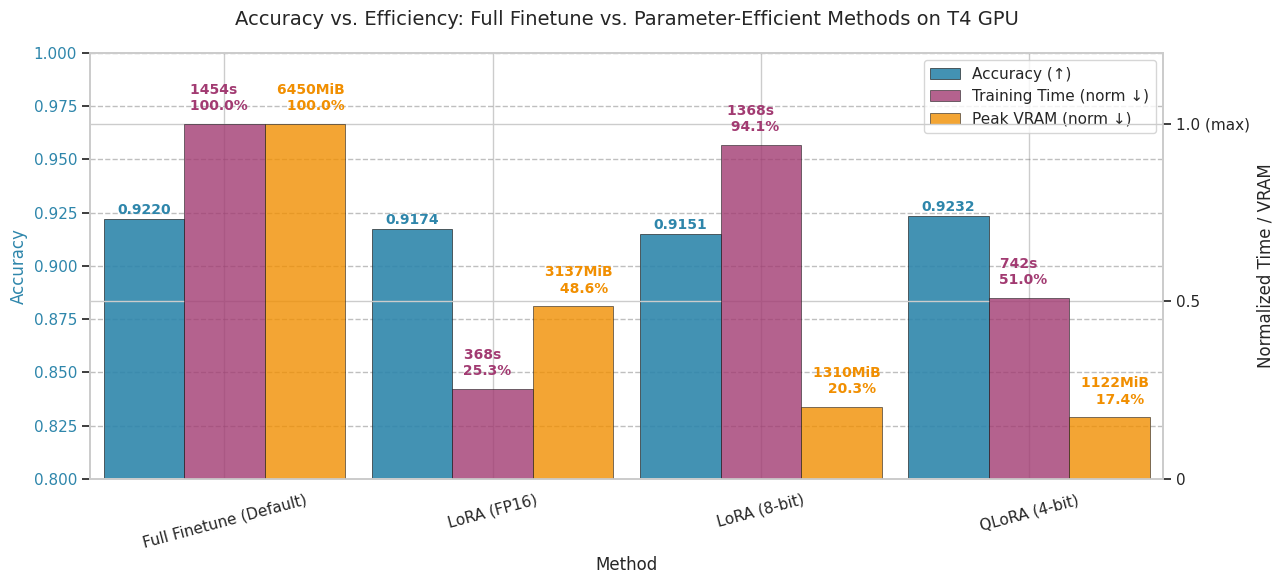

In [ ]:
df=pd.read_csv('../results/csvs/results_of_initialize.csv')
method_to_exclude = 'Full Finetune (FP16)'
df = df[df['Method'] != method_to_exclude].copy()
methods = df['Method'].values


acc = df['Accuracy'].values
time = df['Training Time (s)'].values
vram = df['Peak VRAM'].values
trainable_params_percent = df['Trainable %'].apply(lambda x: float(x.strip('%')) / 100).values.astype(float)
x = np.arange(len(methods))
width = 0.3

# Normalize time and vram for better illustration

time_max = time.max()
vram_max = vram.max()

time_norm = time / time_max
vram_norm = vram / vram_max


fig, ax1 = plt.subplots(figsize=(13, 6))

color_acc = '#2E86AB'
bars_acc = ax1.bar(
    x - width, acc, width, label='Accuracy (↑)',
    color=color_acc, edgecolor='k', linewidth=0.5, alpha=0.9
)

ax1.set_ylabel('Accuracy', color=color_acc, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color_acc)
ax1.set_ylim(0.8, 1)


ax2 = ax1.twinx()
color_time = '#A23B72'
color_vram = '#F18F01'
color_trainable = '#6BBE45'
bars_time = ax2.bar(
    x, time_norm, width, label='Training Time (norm ↓)',
    color=color_time, edgecolor='k', linewidth=0.5, alpha=0.8
)

bars_vram = ax2.bar(
    x + width, vram_norm, width, label='Peak VRAM (norm ↓)',
    color=color_vram, edgecolor='k', linewidth=0.5, alpha=0.8
)

ax2.set_ylabel('Normalized Time / VRAM', fontsize=12)

ax2.set_ylim(0, 1.2)

ax2.set_yticks([0, 0.5, 1.0])
ax2.set_yticklabels(['0', '0.5', '1.0 (max)'])
ax2.tick_params(axis='x', length=0)

# Add original data for reference
for i in range(len(methods)):
    # Accuracy
    ax1.text(
        x[i] - width, acc[i] + 0.001, f'{acc[i]:.4f}',
        ha='center', va='bottom', fontsize=10,
        color=color_acc, fontweight='bold'
    )

    # Training Time
    ax2.text(
        x[i]-0.03, time_norm[i] + 0.03, f'{time[i]:.0f}s \n {time_norm[i]*100:.1f}%',
        ha='center', va='bottom', fontsize=10,
        color=color_time, fontweight='bold'
    )

    # Peak VRAM（
    ax2.text(
        x[i] + width + 0.03, vram_norm[i] + 0.03, f'{vram[i]:.0f}MiB \n {vram_norm[i]*100:.1f}%',
        ha='center', va='bottom', fontsize=10,
        color=color_vram, fontweight='bold'
    )

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax1.set_xlim(-0.5, len(methods) - 0.5)

ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=15, ha='center')
ax1.set_xlabel('Method', fontsize=12)

ax1.set_title(
    'Accuracy vs. Efficiency: Full Finetune vs. Parameter-Efficient Methods on T4 GPU',
    fontsize=14, pad=20
)

ax1.grid(axis='y', linestyle='--', alpha=0.5, color='gray')

plt.tight_layout()
plt.savefig('../results/figures/accuracy_efficiency_comparison_T4.png', dpi=300, bbox_inches='tight')

plt.show()


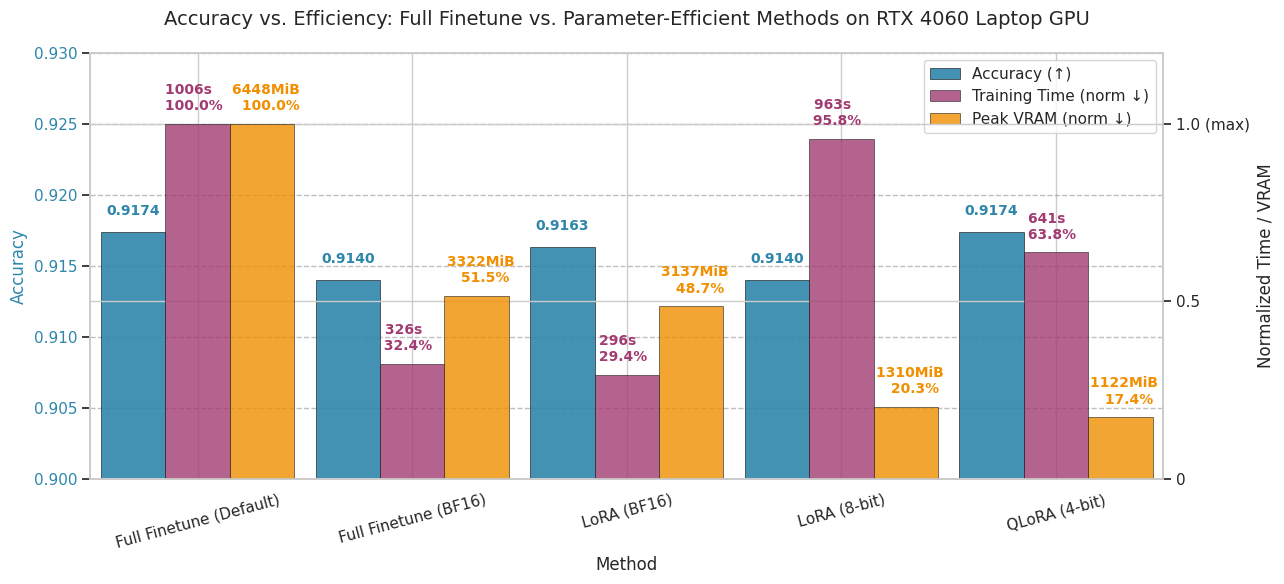

In [ ]:
df=pd.read_csv('../results/csvs/results_of_initialize_4060.csv')

methods = df['Method'].values
acc = df['Accuracy'].values
time = df['Training Time (s)'].values
vram = df['Peak VRAM'].values
trainable_params_percent = df['Trainable %'].apply(lambda x: float(x.strip('%')) / 100).values.astype(float)
x = np.arange(len(methods))
width = 0.3
time_max = time.max()
vram_max = vram.max()

time_norm = time / time_max
vram_norm = vram / vram_max

fig, ax1 = plt.subplots(figsize=(13, 6))

color_acc = '#2E86AB'
bars_acc = ax1.bar(
    x - width, acc, width, label='Accuracy (↑)',
    color=color_acc, edgecolor='k', linewidth=0.5, alpha=0.9
)

ax1.set_ylabel('Accuracy', color=color_acc, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color_acc)
ax1.set_ylim(0.90, 0.93)


ax2 = ax1.twinx()
color_time = '#A23B72'
color_vram = '#F18F01'
color_trainable = '#6BBE45'
bars_time = ax2.bar(
    x, time_norm, width, label='Training Time (norm ↓)',
    color=color_time, edgecolor='k', linewidth=0.5, alpha=0.8
)

bars_vram = ax2.bar(
    x + width, vram_norm, width, label='Peak VRAM (norm ↓)',
    color=color_vram, edgecolor='k', linewidth=0.5, alpha=0.8
)

ax2.set_ylabel('Normalized Time / VRAM', fontsize=12)


ax2.set_ylim(0, 1.2)


ax2.set_yticks([0, 0.5, 1.0])
ax2.set_yticklabels(['0', '0.5', '1.0 (max)'])

ax2.tick_params(axis='x', length=0)

for i in range(len(methods)):
    # Accuracy
    ax1.text(
        x[i] - width, acc[i] + 0.001, f'{acc[i]:.4f}',
        ha='center', va='bottom', fontsize=10,
        color=color_acc, fontweight='bold'
    )

    # Training Time
    ax2.text(
        x[i]-0.03, time_norm[i] + 0.03, f'{time[i]:.0f}s \n {time_norm[i]*100:.1f}%',
        ha='center', va='bottom', fontsize=10,
        color=color_time, fontweight='bold'
    )

    # Peak VRAM
    ax2.text(
        x[i] + width + 0.03, vram_norm[i] + 0.03, f'{vram[i]:.0f}MiB \n {vram_norm[i]*100:.1f}%',
        ha='center', va='bottom', fontsize=10,
        color=color_vram, fontweight='bold'
    )

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax1.set_xlim(-0.5, len(methods) - 0.5)

ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=15, ha='center')
ax1.set_xlabel('Method', fontsize=12)

ax1.set_title(
    'Accuracy vs. Efficiency: Full Finetune vs. Parameter-Efficient Methods on RTX 4060 Laptop GPU',
    fontsize=14, pad=20
)

ax1.grid(axis='y', linestyle='--', alpha=0.5, color='gray')

plt.tight_layout()
plt.savefig('../results/figures/accuracy_efficiency_comparison_4060.png', dpi=300, bbox_inches='tight')

plt.show()


## 1.3 Learning Rate Sweep

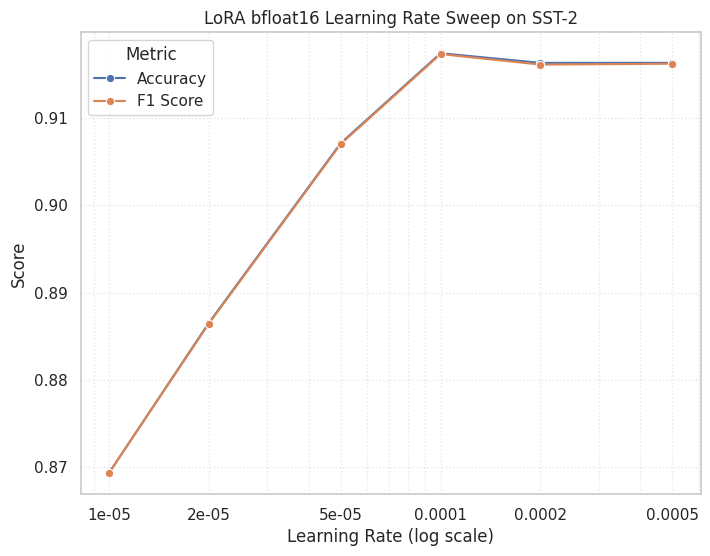

In [ ]:
df_lr=pd.read_csv('../results/csvs/results_lr.csv')
acc=df_lr['Accuracy'].values.astype(float)
f1=df_lr['F1 Score'].values.astype(float)
lr=df_lr['Learning Rate'].values.astype(float)
df_lr_melted = df_lr.melt(id_vars='Learning Rate', value_vars=['Accuracy', 'F1 Score'],
                          var_name='Metric', value_name='Score')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_lr_melted, x='Learning Rate', y='Score', hue='Metric', marker='o')
plt.xscale('log')
plt.xticks(lr, labels=lr)
plt.title('LoRA bfloat16 Learning Rate Sweep on SST-2')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Score')
plt.grid(True, which="both", linestyle=':', alpha=0.5)
plt.savefig('../results/figures/lr_sweep.png', dpi=300)
plt.show()

## 1.4 Random Seed Visualization

========== Robustness Summary ==========
Accuracy: Mean = 0.9145, Std = 0.0021
F1 Score: Mean = 0.9145, Std = 0.0021


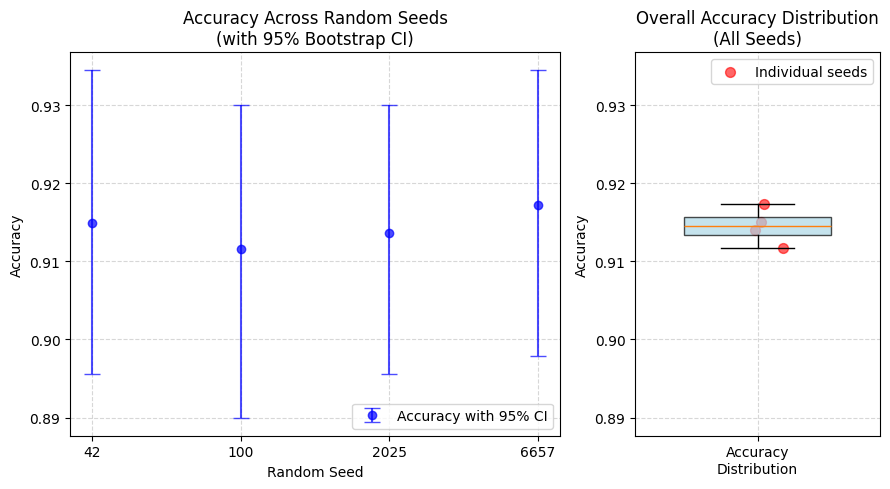

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("../results/csvs/results_seed.csv")

seeds = df["Seed"].values
acc = df["Accuracy"].values
f1 = df["F1 Score"].values
bs_acc = df["BS Mean Acc"].values
bs_f1 = df["BS Mean F1"].values
acc_ci_low = df["BS Acc CI (Low)"].values
acc_ci_high = df["BS Acc CI (High)"].values
f1_ci_low = df["BS F1 CI (Low)"].values
f1_ci_high = df["BS F1 CI (High)"].values


# Calculate Mean ± Std

acc_mean, acc_std = acc.mean(), acc.std()
f1_mean, f1_std = f1.mean(), f1.std()

print("========== Robustness Summary ==========")
print(f"Accuracy: Mean = {acc_mean:.4f}, Std = {acc_std:.4f}")
print(f"F1 Score: Mean = {f1_mean:.4f}, Std = {f1_std:.4f}")
print("========================================")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5),gridspec_kw={'width_ratios': [2, 1]})
original_seeds = seeds
seeds=[1,2,3,4]
yerr_acc = [bs_acc - acc_ci_low, acc_ci_high - bs_acc]
ax1.errorbar(seeds, bs_acc, yerr=yerr_acc, fmt='o', capsize=6, linewidth=1.5,
             color='blue', alpha=0.7, label='Accuracy with 95% CI')
ax1.set_xlabel("Random Seed")
ax1.set_xticks(seeds)
ax1.set_xticklabels([f'{int(s)}' for s in original_seeds])
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy Across Random Seeds\n(with 95% Bootstrap CI)")
ax1.grid(True, linestyle="--", alpha=0.5)
ax1.legend()
box_plot = ax2.boxplot(acc, positions=[1], widths=0.6, patch_artist=True)

box_plot['boxes'][0].set_facecolor('lightblue')
box_plot['boxes'][0].set_alpha(0.7)


jitter = np.random.normal(0, 0.05, size=len(acc))
ax2.scatter(np.ones_like(acc) + jitter, acc, alpha=0.6, color='red',
           s=50, label='Individual seeds')

ax2.set_xlim(0.5, 1.5)
ax2.set_xticks([1])
ax2.set_xticklabels(['Accuracy\nDistribution'])
ax2.set_ylabel("Accuracy")
ax2.set_title("Overall Accuracy Distribution\n(All Seeds)")
ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.5)


y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(y_min, y_max)
ax2.set_ylim(y_min, y_max)

plt.tight_layout()
plt.savefig("../results/figures/robustness_accuracy_combined.png", dpi=300)
plt.show()

## 1.5 Few-Shot Experiments

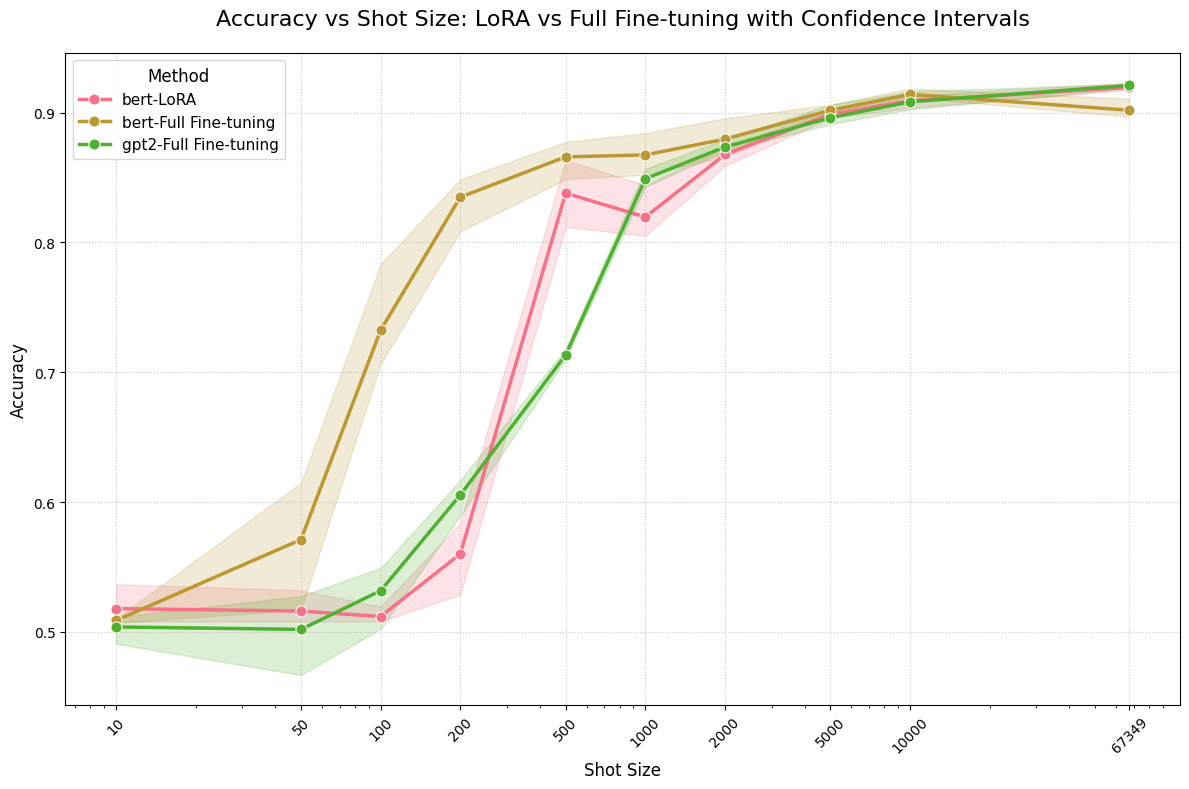

In [ ]:
import ast
df = pd.read_csv('../results/csvs/few_shot_results.csv')
df_gpt2 = pd.read_csv("../results/csvs/results_gpt2_ft_few_shots.csv")
df_gpt2['params_dict'] = df_gpt2['training_parameters'].apply(ast.literal_eval)
df_gpt2['Shot_Size'] = df_gpt2['params_dict'].apply(lambda x: x['few_shot_size']).astype(int)
df_gpt2['Method_Type'] = 'gpt2-Full Fine-tuning'
df_gpt2['Accuracy'] = df_gpt2['validation_accuracy'].rename('Accuracy')
df_gpt2 = df_gpt2[['Method_Type', 'Shot_Size', 'Accuracy']]

df['Method_Type'] = df['Method'].str.extract('(lora|fullft)')[0]

import re
df['Method_Type'] = df['Method'].str.extract('(LoRA|Full Finetune)', flags=re.IGNORECASE)[0]
df['Method_Type'] = df['Method_Type'].fillna('unknown')
df['Method_Type'] = df['Method_Type'].map({
    'LoRA': 'bert-LoRA',
    'lora': 'bert-LoRA',
    'Full Finetune': 'bert-Full Fine-tuning',
    'full finetune': 'bert-Full Fine-tuning'
})


df['Shot_Size'] = df['Shot Size'].astype(int)


df['Accuracy'] = df['Accuracy'].astype(float)
df_clean_bert = df.dropna(subset=['Accuracy', 'Shot_Size', 'Method_Type'])
df_clean_gpt2 = df_gpt2.dropna(subset=['Accuracy', 'Shot_Size', 'Method_Type'])
df = pd.concat([df_clean_bert, df_clean_gpt2], ignore_index=True)
df.to_csv('../results/csvs/few_shot_experiments_combined_results.csv', index=False)


plt.style.use('default')
sns.set_palette("husl")


plt.figure(figsize=(12, 8))


sns.lineplot(data=df, x='Shot_Size', y='Accuracy', hue='Method_Type',
             marker='o', markersize=8, linewidth=2.5, err_style='band',
             errorbar=('ci', 95))


plt.title('Accuracy vs Shot Size: LoRA vs Full Fine-tuning with Confidence Intervals',
          fontsize=16, pad=20)
plt.xlabel('Shot Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(title='Method', title_fontsize=12, fontsize=11)


plt.xscale('log')


shot_sizes = sorted(df['Shot_Size'].unique())
plt.xticks(shot_sizes, labels=shot_sizes, rotation=45)


plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()


plt.savefig('../results/figures/shot_size_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 1.6 Impact of r

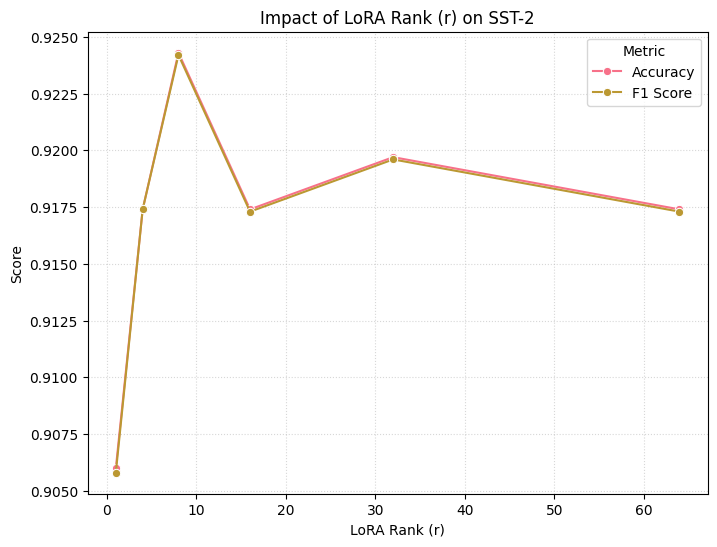

In [ ]:
df_model=pd.read_csv('../results/csvs/sweep_results_r.csv')
acc=df_model['Accuracy'].values.astype(float)
f1=df_model['F1 Score'].values.astype(float)
model_values=df_model['r'].values.astype(int)
df_model_melted = df_model.melt(id_vars='r', value_vars=['Accuracy', 'F1 Score'],
                          var_name='Metric', value_name='Score')

plt.figure(figsize=(8, 6))
sns.lineplot(data=df_model_melted, x='r', y='Score', hue='Metric', marker='o')
plt.title('Impact of LoRA Rank (r) on SST-2')
plt.xlabel('LoRA Rank (r)')
plt.ylabel('Score')
plt.grid(True, linestyle=':', alpha=0.5)
plt.savefig('../results/figures/lora_r_sweep_sst2.png', dpi=300)
plt.show()

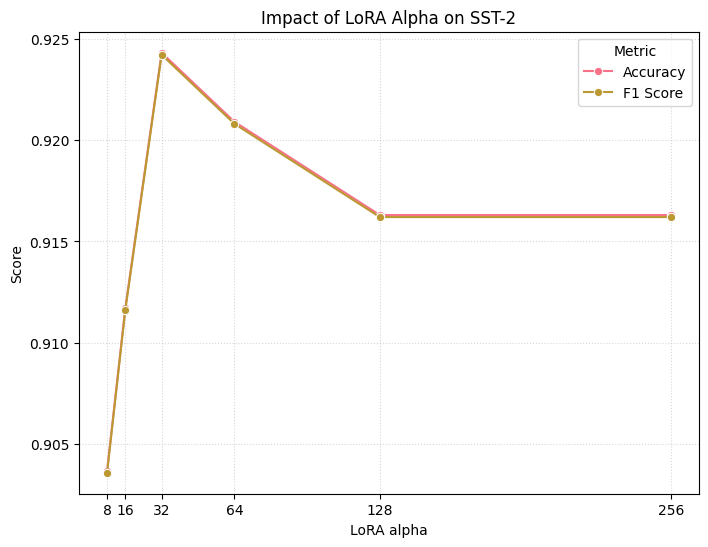

In [ ]:
df_alpha=pd.read_csv('../results/csvs/sweep_results_alpha.csv')
acc=df_alpha['Accuracy'].values.astype(float)
f1=df_alpha['F1 Score'].values.astype(float)
alpha_values=df_alpha['Alpha'].values.astype(int)
df_alpha_melted = df_alpha.melt(id_vars='Alpha', value_vars=['Accuracy', 'F1 Score'],
                          var_name='Metric', value_name='Score')

plt.figure(figsize=(8, 6))
sns.lineplot(data=df_alpha_melted, x='Alpha', y='Score', hue='Metric', marker='o')
plt.title('Impact of LoRA Alpha on SST-2')
plt.xlabel('LoRA alpha')
plt.xticks(alpha_values, labels=alpha_values)
plt.ylabel('Score')
plt.grid(True, linestyle=':', alpha=0.5)
plt.savefig('../results/figures/lora_alpha_sweep_sst2.png', dpi=300)
plt.show()

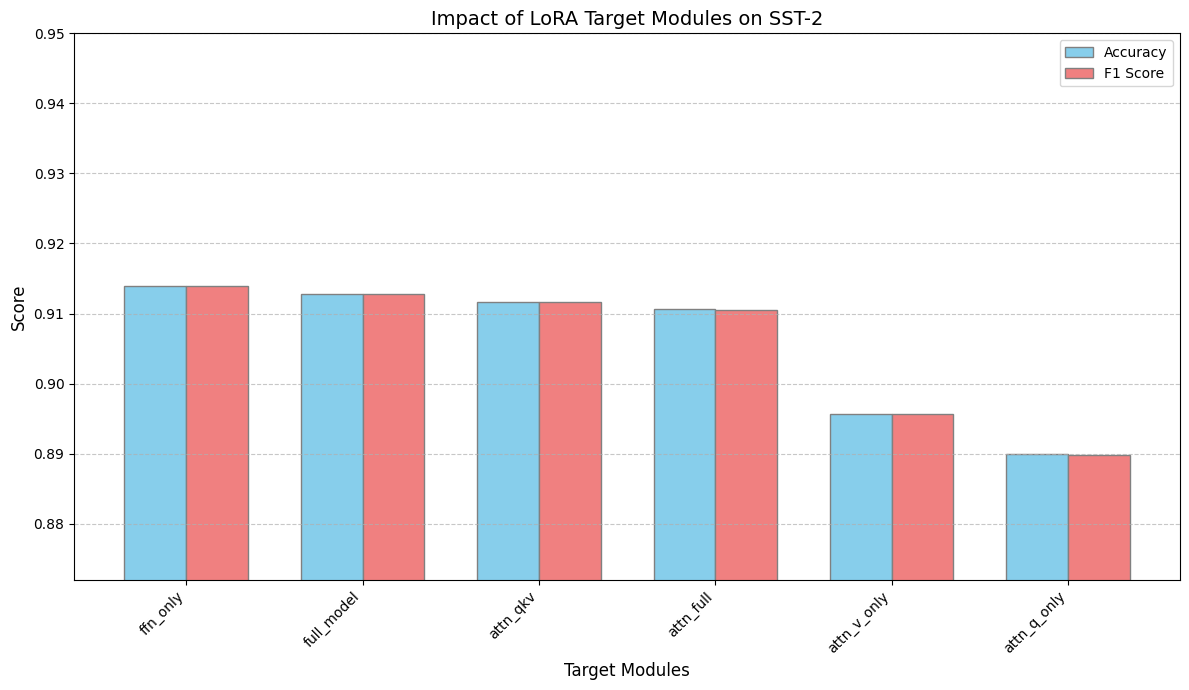

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

file_name = "../results/csvs/sweep_results_target_modules.csv"
df = pd.read_csv(file_name)

def clean_target_modules(module_str):
    try:
        module_list = ast.literal_eval(module_str)
        return ', '.join(module_list)
    except:
        return module_str

df['Clean Target Modules'] = df['Target Modules'].apply(clean_target_modules)

TARGET_MODULES_CONFIGS = {
    "attn_qkv": ["query", "key", "value"],
    "attn_full": ["query", "key", "value", "attention.output.dense"],
    "ffn_only": ["intermediate.dense", "output.dense"],
    "attn_q_only": ["query"],
    "attn_v_only": ["value"],
    "full_model": ["query", "key", "value", "attention.output.dense", "intermediate.dense", "output.dense"],
}

reverse_map = {}
for simplified_label, module_list in TARGET_MODULES_CONFIGS.items():
    clean_module_string = ', '.join(module_list)
    reverse_map[clean_module_string] = simplified_label

df['Simplified Modules'] = df['Clean Target Modules'].map(reverse_map).fillna(df['Clean Target Modules'])


plot_data = df[['Simplified Modules', 'Accuracy', 'F1 Score']].copy()

plot_data['Accuracy'] = pd.to_numeric(plot_data['Accuracy'], errors='coerce')
plot_data['F1 Score'] = pd.to_numeric(plot_data['F1 Score'], errors='coerce')

plot_data.dropna(subset=['Accuracy', 'F1 Score'], inplace=True)
plot_data = plot_data.sort_values(by='F1 Score', ascending=False)

labels = plot_data['Simplified Modules'].tolist()
accuracy_values = plot_data['Accuracy'].tolist()
f1_score_values = plot_data['F1 Score'].tolist()

fig, ax = plt.subplots(figsize=(12, 7))

bar_width = 0.35
x = range(len(labels))
r1 = [i - bar_width/2 for i in x]
r2 = [i + bar_width/2 for i in x]

ax.bar(r1, accuracy_values, color='skyblue', width=bar_width, edgecolor='grey', label='Accuracy')
ax.bar(r2, f1_score_values, color='lightcoral', width=bar_width, edgecolor='grey', label='F1 Score')

ax.set_xlabel('Target Modules', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Impact of LoRA Target Modules on SST-2', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

min_score = min(min(accuracy_values), min(f1_score_values))
ax.set_ylim(min_score * 0.98, 0.95)

plt.tight_layout()
plt.savefig('../results/figures/lora_target_modules_sst2.png', dpi=300)

plt.show()

## 1.7 Freeze Experiments

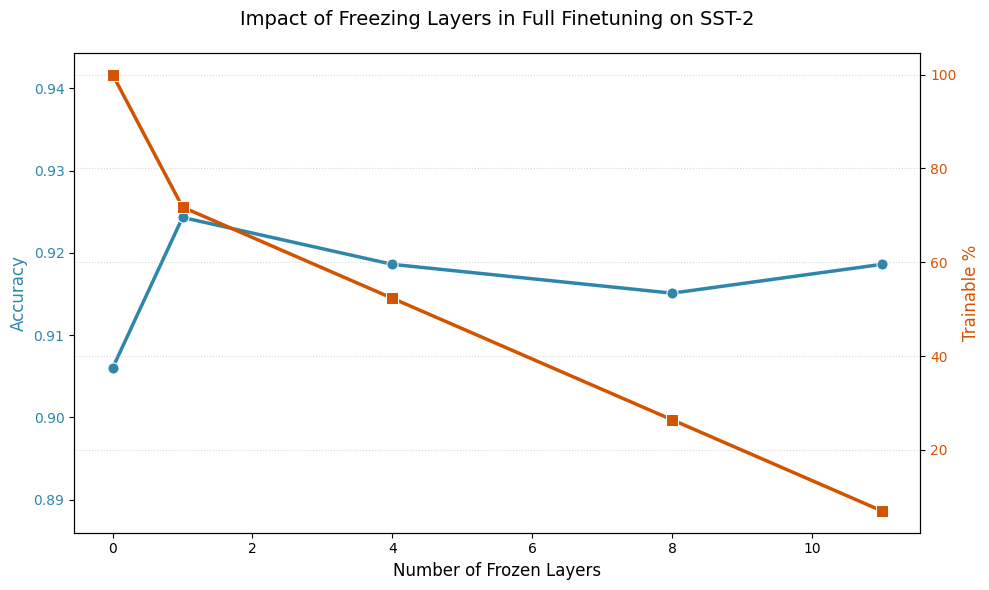

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read and preprocess data
df_freeze = pd.read_csv('../results/csvs/freeze_layer_results.csv')

# Convert accuracy to float and clean trainable percentage
df_freeze['Accuracy'] = df_freeze['Accuracy'].astype(float)
df_freeze['Trainable %'] = df_freeze['Trainable %'].str.rstrip('%').astype(float)

# Extract number of frozen layers and keep original method name for legend
df_freeze['Method'] = df_freeze['Method'].str.replace(' Layers', '')
df_freeze['Frozen Layers'] = df_freeze['Method'].str.replace('Full - Freeze ', '').astype(int)
df_freeze['Method Name'] = df_freeze['Method']  # Keep original for reference

# Create the plot
plt.figure(figsize=(10, 6))

# Primary axis - Accuracy
ax1 = plt.gca()
sns.lineplot(data=df_freeze, x='Frozen Layers', y='Accuracy', marker='o',
             label='Accuracy', color='#2E86AB', ax=ax1, linewidth=2.5, markersize=8)

# Secondary axis - Trainable %
ax2 = plt.twinx()
sns.lineplot(data=df_freeze, x='Frozen Layers', y='Trainable %', marker='s',
             label='Trainable %', color='#D35400', ax=ax2, linewidth=2.5, markersize=8)

# Customize the plot
plt.title('Impact of Freezing Layers in Full Finetuning on SST-2', fontsize=14, pad=20)

# Primary y-axis
ax1.set_xlabel('Number of Frozen Layers', fontsize=12)
ax1.set_ylabel('Accuracy', color='#2E86AB', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#2E86AB')

# Set appropriate y-axis limits for accuracy (adjust based on your data range)
accuracy_min = df_freeze['Accuracy'].min()
accuracy_max = df_freeze['Accuracy'].max()
ax1.set_ylim([accuracy_min - 0.02, accuracy_max + 0.02])  # Add some padding

# Secondary y-axis
ax2.set_ylabel('Trainable %', color='#D35400', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#D35400')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

# Remove individual legends
ax1.get_legend().remove()
ax2.get_legend().remove()

plt.grid(True, linestyle=':', alpha=0.5)

# Save and show
plt.tight_layout()
plt.savefig('../results/figures/ft_freeze.png', dpi=300, bbox_inches='tight')
plt.show()

## 1.8 Overfit

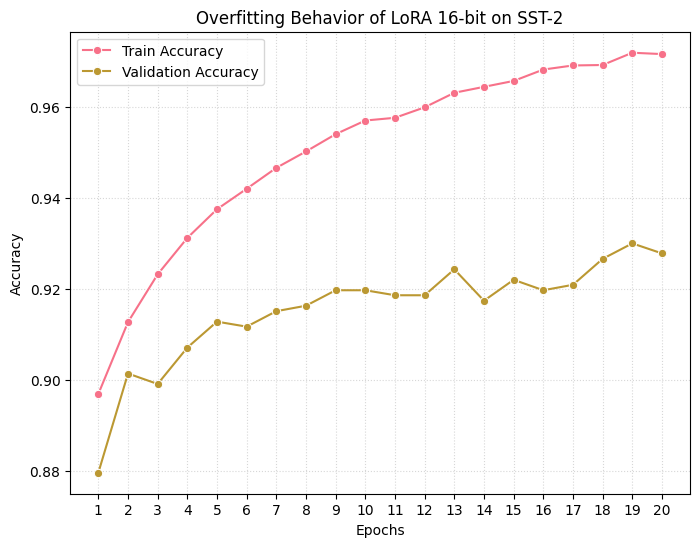

In [ ]:
df_overfit=pd.read_csv('../results/csvs/overfit_results.csv')
df_overfit['Epoch'] = df_overfit['Epoch'].astype(int)
df_overfit['train_accuracy'] = df_overfit['train_accuracy'].astype(float)
df_overfit['val_accuracy'] = df_overfit['val_accuracy'].astype(float)


plt.figure(figsize=(8, 6))
sns.lineplot(data=df_overfit, x='Epoch', y='train_accuracy', marker='o', label='Train Accuracy')
sns.lineplot(data=df_overfit, x='Epoch', y='val_accuracy', marker='o', label='Validation Accuracy')
plt.title('Overfitting Behavior of LoRA 16-bit on SST-2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle=':', alpha=0.5)
plt.xticks(df_overfit['Epoch'].unique())
plt.savefig('../results/figures/lora_16bit_overfitting_sst2.png', dpi=300)
plt.show()

## 1.9 Transfer Learning (Zero-shot on Target Task)

Loaded 648 module data entries


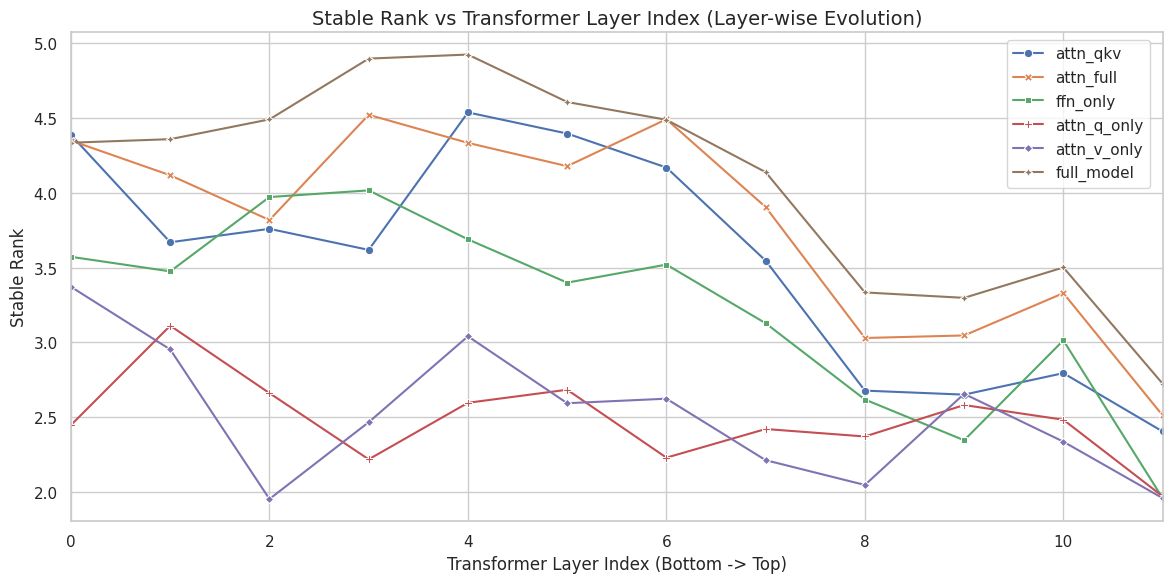

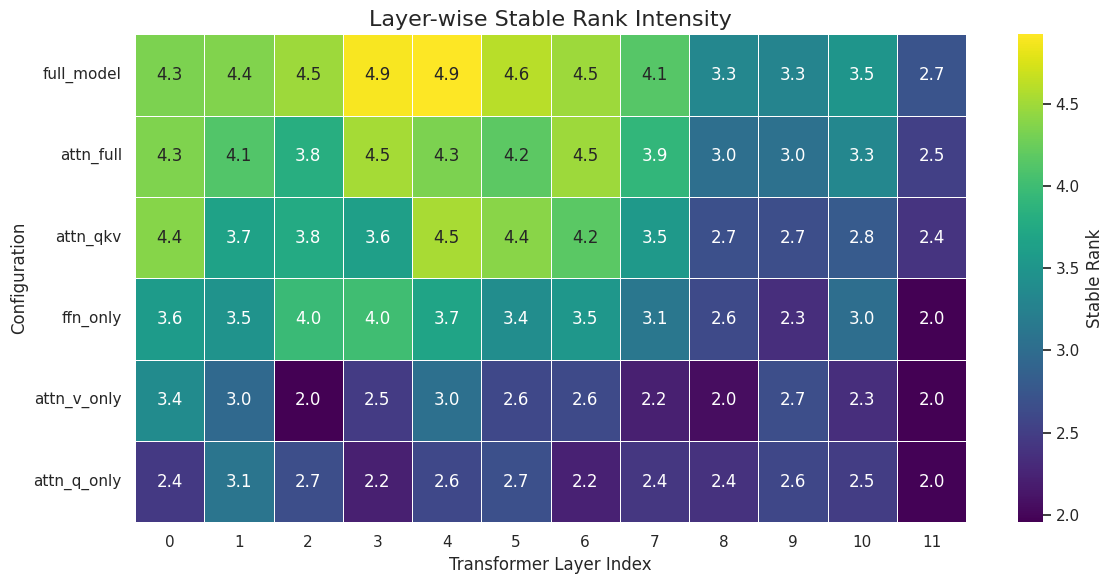

/tmp/ipython-input-3607062992.py:89: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(


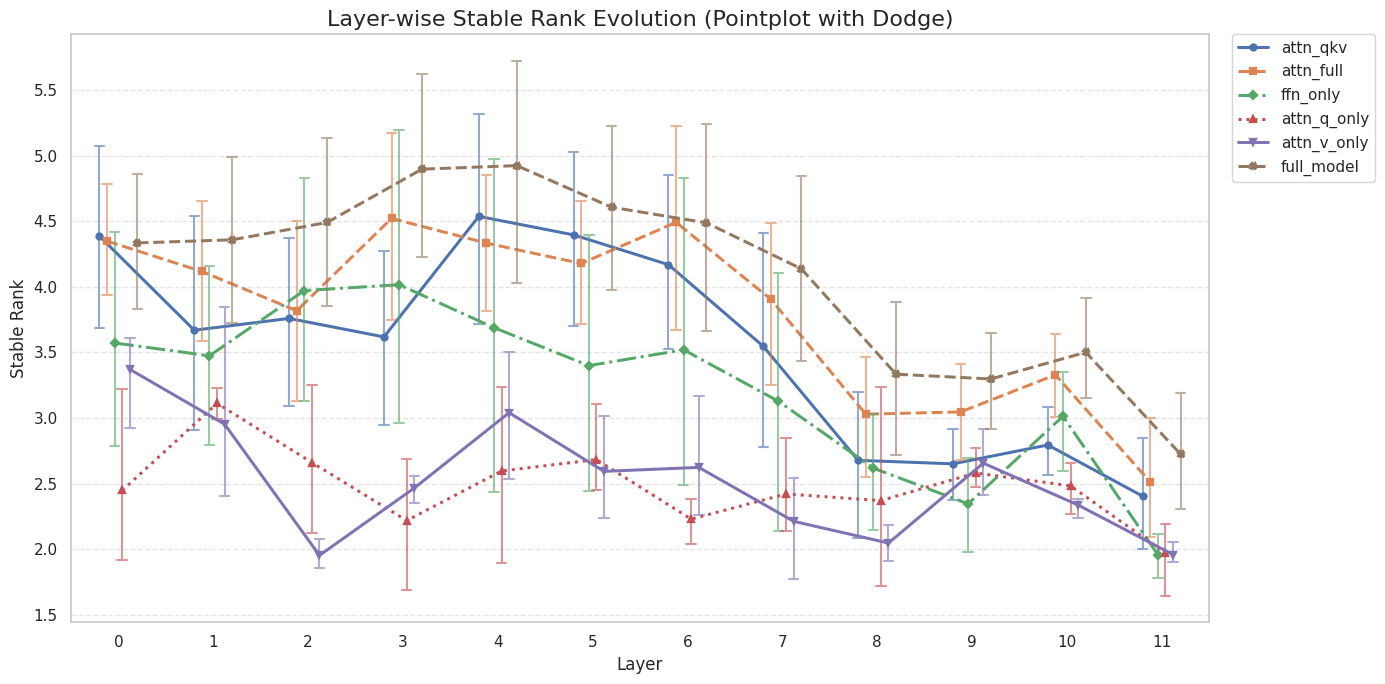

/tmp/ipython-input-3607062992.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


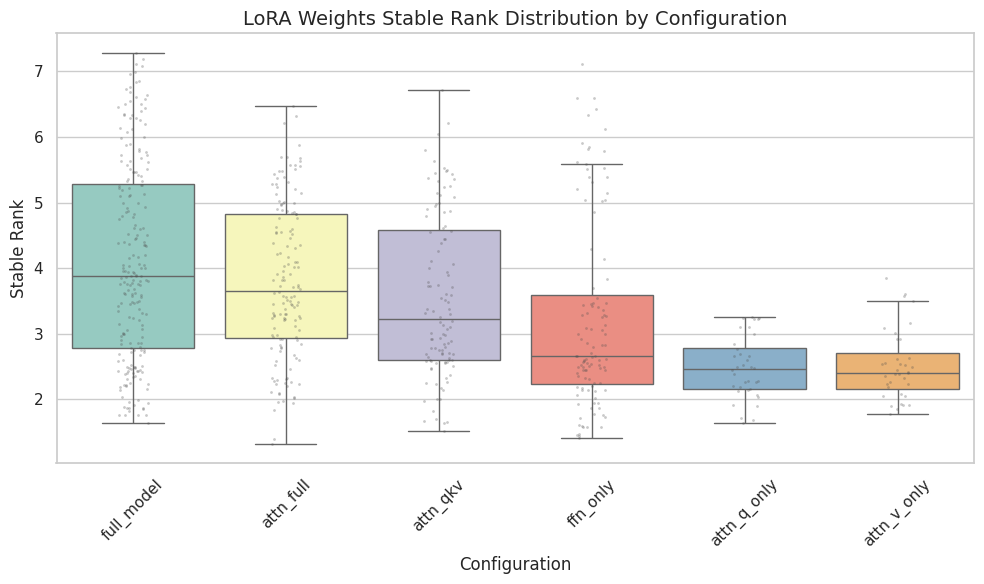

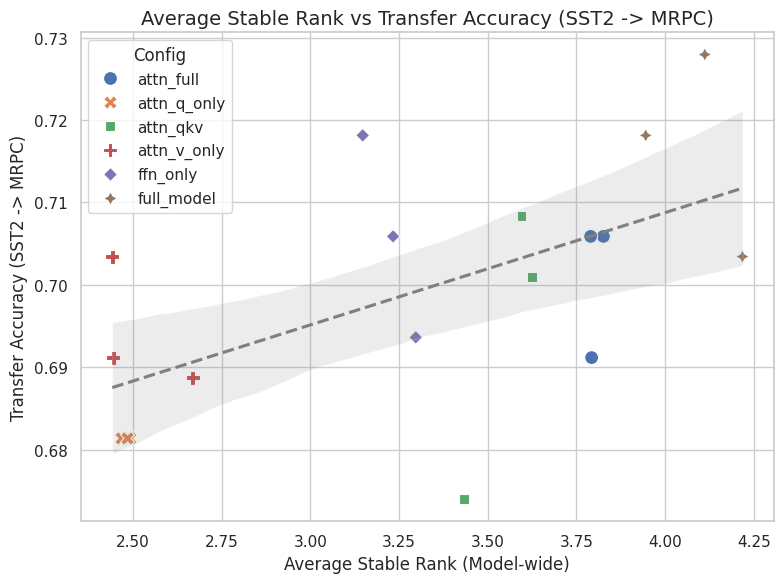

In [6]:
# set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

def parse_results(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    records = []

    for config_name, config_data in data.items():
        mean_acc = config_data.get('mean_accuracy', 0)

        # Iterate over each seed
        for seed, seed_data in config_data['seeds'].items():
            transfer_acc = seed_data['transfer_accuracy']
            svd_analysis = seed_data['svd_analysis']

            # Collect all ranks for this seed
            all_ranks = []

            for module_name, metrics in svd_analysis.items():
                # Extract layer number from module name (e.g., "base_model.model.bert.encoder.layer.0...." -> 0)
                layer_match = re.search(r'layer\.(\d+)', module_name)
                layer_idx = int(layer_match.group(1)) if layer_match else -1

                # Determine module type (Query, Key, Value, Dense)
                mod_type = "Other"
                if "query" in module_name: mod_type = "Query"
                elif "key" in module_name: mod_type = "Key"
                elif "value" in module_name: mod_type = "Value"
                elif "dense" in module_name: mod_type = "Dense (FFN/Output)"

                stable_rank = metrics['stable_rank']
                rank_95 = metrics['rank_95']

                all_ranks.append(stable_rank)

                records.append({
                    "Config": config_name,
                    "Seed": seed,
                    "Layer": layer_idx,
                    "Module": module_name,
                    "Module Type": mod_type,
                    "Stable Rank": stable_rank,
                    "Rank 95": rank_95,
                    "Transfer Acc": transfer_acc # This accuracy is for the entire model, not individual layers
                })

    return pd.DataFrame(records)

# ================= Plotting Functions =================

def plot_layer_wise_rank(df,exp_name):
    """Figure 1: Trend of Rank across layers under different configurations"""
    plt.figure(figsize=(12, 6))

    # Only consider layers with index >= 0
    plot_df = df[df["Layer"] >= 0]

    sns.lineplot(
        data=plot_df,
        x="Layer",
        y="Stable Rank",
        hue="Config",
        style="Config",
        markers=True,
        dashes=False,
        err_style=None
    )

    plt.title("Stable Rank vs Transformer Layer Index (Layer-wise Evolution)", fontsize=14)
    plt.xlim(0, plot_df["Layer"].max())
    plt.xlabel("Transformer Layer Index (Bottom -> Top)", fontsize=12)
    plt.ylabel("Stable Rank", fontsize=12)
    plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"../results/figures/{exp_name}_layer_wise_stable_rank_evolution.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_layer_wise_clean(df, exp_name):
    plt.figure(figsize=(14, 7))

    plot_df = df[df["Layer"] >= 0]

    # Use pointplot instead of lineplot
    # dodge=True to offset overlapping points, capsize adds caps, err_kws adjusts error bar transparency
    sns.pointplot(
        data=plot_df,
        x="Layer",
        y="Stable Rank",
        hue="Config",
        markers=["o", "s", "D", "^", "v", "X"], # Different shapes of points
        linestyles=["-", "--", "-.", ":", "-", "--"], # Different line styles
        dodge=0.4,       # Key: offset points by 0.4 units to prevent overlap
        capsize=0.1,     # Size of error bar caps
        err_kws={'linewidth': 1.5, 'alpha': 0.6}, # Make error bars thinner and more transparent
        scale=0.8        # Slightly thinner points and lines
    )

    plt.title("Layer-wise Stable Rank Evolution (Pointplot with Dodge)", fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.5) # Only keep horizontal grid lines, and make them lighter
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.tight_layout()
    plt.show()

def plot_layer_wise_heatmap(df, exp_name):
    plt.figure(figsize=(12, 6))

    # 1. Calculate the average Rank for each Config at each layer
    heatmap_data = df[df["Layer"] >= 0].groupby(["Config", "Layer"])["Stable Rank"].mean().reset_index()

    # 2. Convert to a pivot table: rows are Config, columns are Layer
    heatmap_matrix = heatmap_data.pivot(index="Config", columns="Layer", values="Stable Rank")

    # 3. Sort configurations by their mean Rank across layers
    mean_ranks = heatmap_matrix.mean(axis=1).sort_values(ascending=False)
    heatmap_matrix = heatmap_matrix.loc[mean_ranks.index]

    # 4. Plotting
    sns.heatmap(
        heatmap_matrix,
        annot=True,     # Show values in cells
        fmt=".1f",      # One decimal place
        cmap="viridis", # Or "coolwarm", "Magma"
        linewidths=.5,  # Add white lines between cells
        cbar_kws={'label': 'Stable Rank'}
    )

    plt.title("Layer-wise Stable Rank Intensity", fontsize=16)
    plt.xlabel("Transformer Layer Index")
    plt.ylabel("Configuration")
    plt.tight_layout()
    plt.savefig(f"../results/figures/{exp_name}_layer_wise_stable_rank_heatmap.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_config_distribution(df, exp_name):
    """Figure 2: Overall Rank Distribution Comparison by Configuration"""
    plt.figure(figsize=(10, 6))

    # Sort configurations by median Rank
    order = df.groupby("Config")["Stable Rank"].median().sort_values(ascending=False).index

    sns.boxplot(
        data=df,
        x="Config",
        y="Stable Rank",
        order=order,
        palette="Set3",
        showfliers=False
    )
    sns.stripplot(
        data=df,
        x="Config",
        y="Stable Rank",
        order=order,
        color=".3",
        alpha=0.3,
        size=2
    )

    plt.title("LoRA Weights Stable Rank Distribution by Configuration", fontsize=14)
    plt.savefig(f"../results/figures/{exp_name}_config_stable_rank_distribution.png", dpi=300, bbox_inches='tight')
    plt.xlabel("Configuration", fontsize=12)
    plt.ylabel("Stable Rank", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_correlation(df, exp_name):
    """Figure 3: Correlation between Average Rank and Transfer Accuracy"""
    # Aggregate by Config and Seed to compute the average Rank for each experiment
    agg_df = df.groupby(["Config", "Seed"]).agg({
        "Stable Rank": "mean",
        "Transfer Acc": "mean"
    }).reset_index()

    plt.figure(figsize=(8, 6))

    sns.scatterplot(
        data=agg_df,
        x="Stable Rank",
        y="Transfer Acc",
        hue="Config",
        s=100, # 点的大小
        style="Config"
    )

    # Simple linear fit
    sns.regplot(
        data=agg_df,
        x="Stable Rank",
        y="Transfer Acc",
        scatter=False,
        color="grey",
        line_kws={"linestyle": "--"}
    )

    plt.title("Average Stable Rank vs Transfer Accuracy (SST2 -> MRPC)", fontsize=14)
    plt.xlabel("Average Stable Rank (Model-wide)", fontsize=12)
    plt.ylabel("Transfer Accuracy (SST2 -> MRPC)", fontsize=12)
    plt.savefig(f"../results/figures/{exp_name}_stable_rank_vs_transfer_accuracy.png", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

# ================= Execute =================
# Assume your results file is at ./lora_transfer_results/transfer_results.json
# If it's a single seed file, you need to merge first or change the logic to read the folder
if __name__ == "__main__":
    # Replace with your actual path
    json_path = "../results/transfer learning/lora_transfer_results_new/transfer_results.json"
    exp_name = "LoRA Transfer Learning Stable Rank Analysis with rank=8"
    try:
        df = parse_results(json_path)
        print(f"Loaded {len(df)} module data entries")

        plot_layer_wise_rank(df, exp_name)
        plot_layer_wise_heatmap(df, exp_name)
        plot_layer_wise_clean(df, exp_name)
        plot_config_distribution(df, exp_name)
        plot_correlation(df, exp_name)
    except FileNotFoundError:
        print("Result file not found, please check the path.")

Loaded 648 module data entries


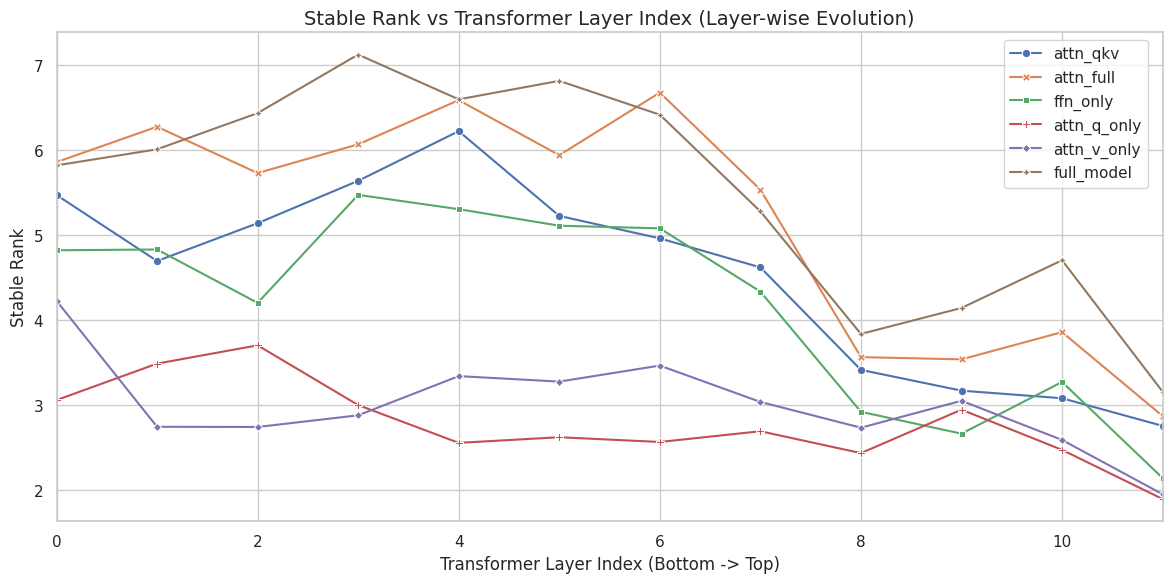

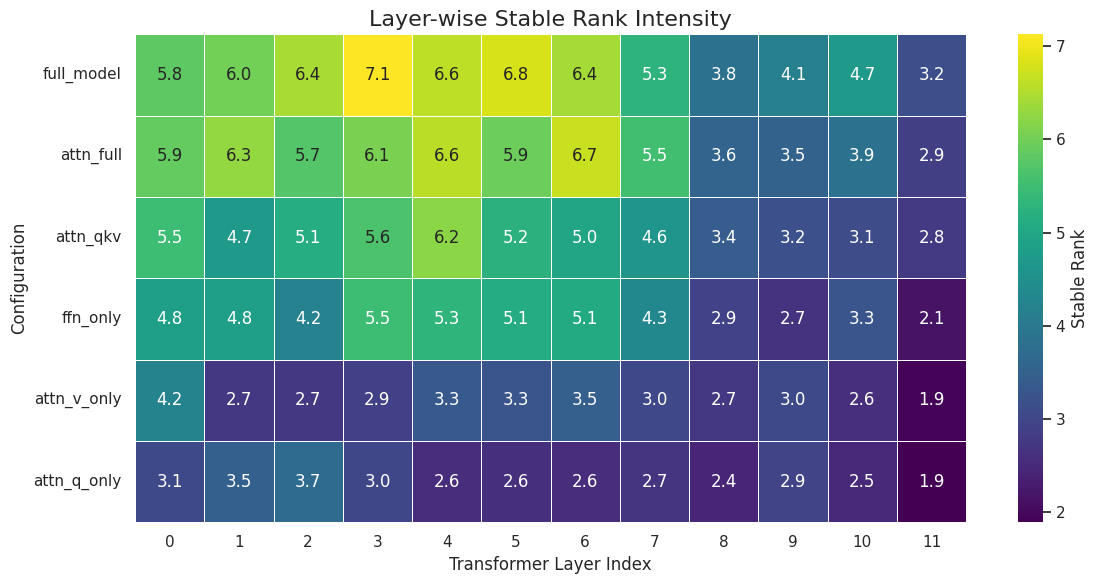

/tmp/ipython-input-3607062992.py:89: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(


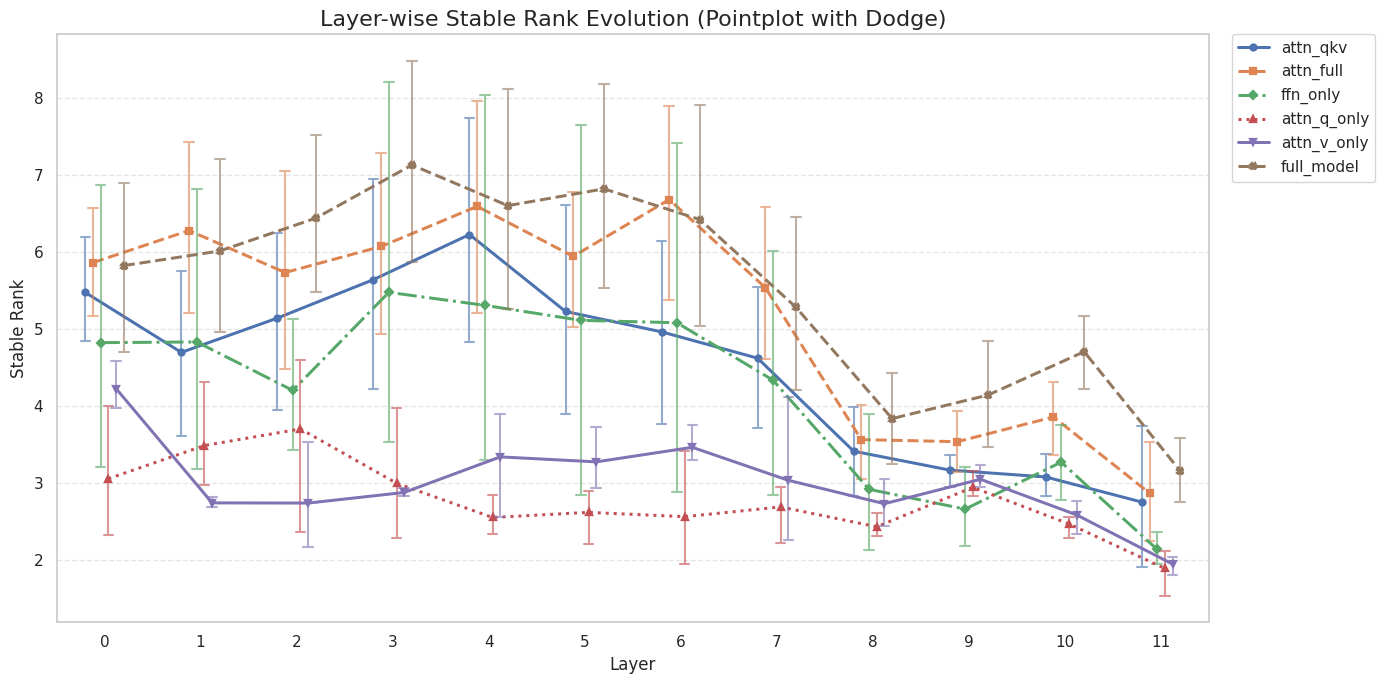

/tmp/ipython-input-3607062992.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


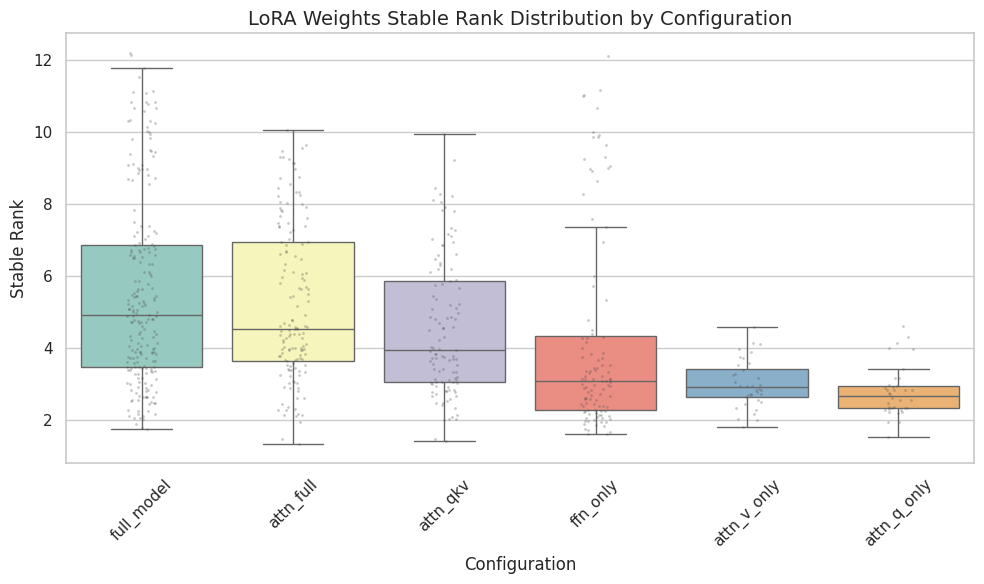

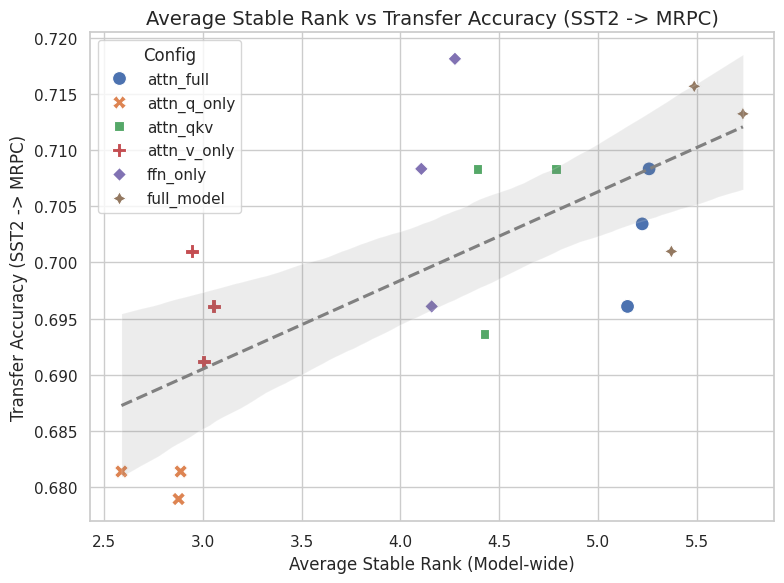

In [7]:
if __name__ == "__main__":
    # Replace with your actual path
    json_path = "../results/transfer learning/lora_transfer_results_new_r16/transfer_results.json"
    exp_name = "LoRA Transfer Learning Stable Rank Analysis with rank=16"
    try:
        df = parse_results(json_path)
        print(f"Loaded {len(df)} module data entries")

        plot_layer_wise_rank(df, exp_name)
        plot_layer_wise_heatmap(df, exp_name)
        plot_layer_wise_clean(df, exp_name)
        plot_config_distribution(df, exp_name)
        plot_correlation(df, exp_name)
    except FileNotFoundError:
        print("Result file not found, please check the path.")

# 2. Train Our Model (about 30min on T4 GPU)

In [ ]:
import os, torch, time, sys, seaborn as sns, numpy as np, evaluate, pandas as pd, matplotlib.pyplot as plt, warnings
from datasets import load_dataset, DatasetDict, concatenate_datasets
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    BitsAndBytesConfig,
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training
)
from sklearn.metrics import f1_score
os.sys.path.append('../src')
from config import *
from utils import build_default_training_args, build_default_lora_config, train_and_evaluate_unified, few_shot_train_and_evaluate_unified, set_precision_for_gpu, run_epoch_control_unified, run_data_centric_experiment_unified, load_and_tokenize_dataset

[GPU] Tesla T4
[Compute Capability] 7.5
[Selected Precision] FP16


In [ ]:
# 2. Basic configurations
sns.set_theme(style="whitegrid")
os.environ["WANDB_DISABLED"] = "true"
warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
_, precision_str, _ = set_precision_for_gpu()

Using device: cuda
GPU Name: Tesla T4


In [ ]:
# 3. Load Dataset
raw_dataset = load_dataset("glue", TASK) # → DatasetDict
tokenizer, train_dataset, eval_dataset = load_and_tokenize_dataset(TASK) # → DatasetDict
print("\n--- Datasets loaded and tokenized successfully. ---")
print(f"Train dataset size: {len(train_dataset)}") # type: ignore
print(f"Eval dataset size: {len(eval_dataset)}\n") # type: ignore


--- 3. Preparing Data ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]


--- Datasets loaded and tokenized successfully. ---
Train dataset size: 67349
Eval dataset size: 872



In [ ]:
experiment = {
f"LoRA ({precision_str})": {"method": "lora_16bit", "lr": BEST_LR, "seed": BEST_SEED},
}
results=[]
for name, config in experiment.items():
    print(f"\n=== Experiment: {name} ===")
    train_and_evaluate_unified(name, config, results, train_dataset, eval_dataset, bootstrap=True, delete_checkpoints=False, epochs=5)
print("Model training and evaluation completed.")
print("\nFinal Results:")
print(f"Model: {experiment}, Method: LoRA ({precision_str}), LR: {BEST_LR}, Seed: {BEST_SEED}, Accuracy and F1 Scores:{results['Accuracy']}, {results['F1 Score']}")


=== Experiment: LoRA (FP16) ===


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.278500,0.253906,0.893349,0.893231
2,0.230000,0.221191,0.916284,0.916284
3,0.207200,0.228760,0.910550,0.910483
4,0.192100,0.235474,0.913991,0.913882
5,0.179500,0.234741,0.912844,0.912766



[Bootstrap] Starting 1000 resampling iterations...
{'Method': 'LoRA (FP16)', 'VRAM Mode': 'FP16', 'Seed': 6657, 'r': 16, 'Learning Rate': 0.0001, 'Shot Size': 67349, 'Freeze Layers': 0, 'Trainable %': '0.8030%', 'Peak VRAM': 3137.9736328125, 'Accuracy': '0.9128', 'F1 Score': '0.9128', 'BS Mean Acc': '0.9125', 'BS Mean F1': '0.9124', 'BS F1 CI (Low)': '0.8930', 'BS F1 CI (High)': '0.9295', 'Training Time (s)': '625.4', 'Time per Epoch (s)': '125.1'}
{'Method': 'LoRA (FP16)', 'VRAM Mode': 'FP16', 'Seed': 6657, 'r': 16, 'Learning Rate': 0.0001, 'Shot Size': 67349, 'Freeze Layers': 0, 'Trainable %': '0.8030%', 'Peak VRAM': 3137.9736328125, 'Accuracy': '0.9128', 'F1 Score': '0.9128', 'BS Mean Acc': '0.9125', 'BS Mean F1': '0.9124', 'BS F1 CI (Low)': '0.8930', 'BS F1 CI (High)': '0.9295', 'Training Time (s)': '625.4', 'Time per Epoch (s)': '125.1'}


# 3. Gradio-based Graphical User Interface

In [8]:
# Make sure to run the app from the src directory
%cd ../src
!python app.py
# Click the share url to view the Gradio app

/content/drive/MyDrive/pj/src
2025-12-07 08:03:35.041021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765094615.060474    1785 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765094615.066413    1785 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765094615.081226    1785 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765094615.081253    1785 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765094615.081257    1785 computation_placer.